In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from dataset_utils import *

seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

### Baseline Model

First we start by creating the baseline model, using all the available training and test data.  
To keep the tests quick, we're going to keep the epochs low.

In [2]:
batch_size = 128
epochs = 3
training_to_augment_size = 15000

In [3]:
def create_model():
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [4]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# normalise input data
x_train = normalise(x_train)
x_test = normalise(x_test)

print_dataset_summary("x_train", x_train)
print_dataset_summary("y_train", y_train)
print_dataset_summary("x_test", x_test)

labels_train = keras.utils.to_categorical(y_train, num_classes)
labels_test = keras.utils.to_categorical(y_test, num_classes)

model = create_model()
# model.summary()

model.fit(x_train, labels_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, labels_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_train shape: (60000, 28, 28, 1) <class 'numpy.ndarray'>
y_train shape: (60000,) <class 'numpy.ndarray'>
x_test shape: (10000, 28, 28, 1) <class 'numpy.ndarray'>
Epoch 1/3
422/422 [==============================] - 7s 16ms/step - loss: 0.7645 - accuracy: 0.7626 - val_loss: 0.0872 - val_accuracy: 0.9757
Epoch 2/3
422/422 [==============================] - 7s 16ms/step - loss: 0.1220 - accuracy: 0.9634 - val_loss: 0.0599 - val_accuracy: 0.9830
Epoch 3/3
422/422 [==============================] - 7s 16ms/step - loss: 0.0864 - accuracy: 0.9729 - val_loss: 0.0453 - val_accuracy: 0.9883
Test loss: 0.04668140038847923
Test accuracy: 0.9848999977111816


### Augmenting data

Let's define what augmentation means. For this application we're going to apply some simple transformations:  
* Some rotation,
* scaling,
* translation in x and y.


In [5]:
def augment(dataset):
    augment_model = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomRotation(0.3),
            layers.experimental.preprocessing.RandomZoom(0.1),
            layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
        ]
    )
    
    augmented_dataset = dataset
    x, y = dataset
    assert x.shape[0] == y.shape[0]
    return augment_model(x).numpy(), y

And now let's augment some data.

In [6]:
# transform only a sample of the data
(x_small, y_small) = choice((x_train, y_train), training_to_augment_size)

# no need to normalise, because we're choosing from normalised data

# augment data
(x_augmented, y_augmented) = augment((x_small, y_small))
print_dataset_summary("x_augmented", x_augmented)
print_dataset_summary("y_augmented", y_augmented)

# convert class vectors to binary class matrices
labels_augmented = keras.utils.to_categorical(y_augmented, num_classes)

x_augmented shape: (15000, 28, 28, 1) <class 'numpy.ndarray'>
y_augmented shape: (15000,) <class 'numpy.ndarray'>


Here are some examples of augmented images

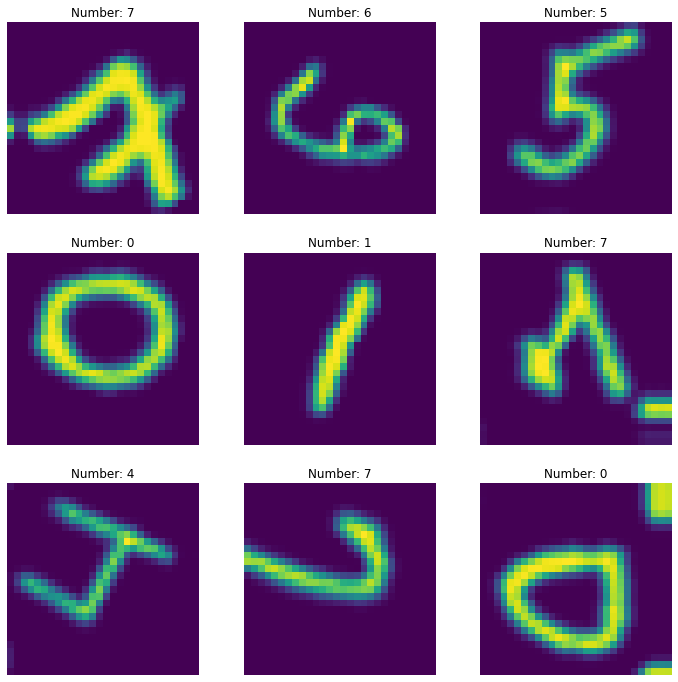

In [7]:
view_images(choice((x_augmented, y_augmented), 9), (12, 12))

To test the images, we start by training the model with the augmented data only.

In [8]:
model = create_model()

model.fit(x_augmented, labels_augmented, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, labels_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/3
106/106 [==============================] - 2s 16ms/step - loss: 2.1336 - accuracy: 0.2167 - val_loss: 1.4358 - val_accuracy: 0.5280
Epoch 2/3
106/106 [==============================] - 2s 15ms/step - loss: 1.4687 - accuracy: 0.4951 - val_loss: 1.1133 - val_accuracy: 0.6487
Epoch 3/3
106/106 [==============================] - 2s 15ms/step - loss: 1.1953 - accuracy: 0.6047 - val_loss: 0.9352 - val_accuracy: 0.6987
Test loss: 0.4585875868797302
Test accuracy: 0.8657000064849854


And to complete the analysis, we train the model again but this time with the original training and augmented data together.

In [9]:
x_all = np.concatenate((x_train, x_augmented))
y_all = np.concatenate((y_train, y_augmented))

# no need to normalise, because we're concatenating normalised data

print_dataset_summary("x_all", x_all)
print_dataset_summary("y_all", y_all)

labels_all = keras.utils.to_categorical(y_all, num_classes)

model = create_model()

model.fit(x_all, labels_all, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, labels_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_all shape: (75000, 28, 28, 1) <class 'numpy.ndarray'>
y_all shape: (75000,) <class 'numpy.ndarray'>
Epoch 1/3
528/528 [==============================] - 9s 16ms/step - loss: 0.8806 - accuracy: 0.7289 - val_loss: 1.4373 - val_accuracy: 0.5227
Epoch 2/3
528/528 [==============================] - 8s 16ms/step - loss: 0.2695 - accuracy: 0.9145 - val_loss: 1.1516 - val_accuracy: 0.6125
Epoch 3/3
528/528 [==============================] - 8s 15ms/step - loss: 0.2140 - accuracy: 0.9323 - val_loss: 0.9535 - val_accuracy: 0.6857
Test loss: 0.04907942935824394
Test accuracy: 0.9858999848365784


### Extra

To terminate, let's try to replace the whole dataset with augmented data.

In [10]:
# augment data
(x_replaced, y_replaced) = augment((x_train, y_train))
print_dataset_summary("x_replaced", x_replaced)
print_dataset_summary("y_replaced", y_replaced)

# convert class vectors to binary class matrices
labels_replaced = keras.utils.to_categorical(y_replaced, num_classes)

model = create_model()

model.fit(x_replaced, labels_replaced, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, labels_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

x_replaced shape: (60000, 28, 28, 1) <class 'numpy.ndarray'>
y_replaced shape: (60000,) <class 'numpy.ndarray'>
Epoch 1/3
422/422 [==============================] - 7s 16ms/step - loss: 1.7387 - accuracy: 0.3845 - val_loss: 0.8769 - val_accuracy: 0.7262
Epoch 2/3
422/422 [==============================] - 6s 15ms/step - loss: 0.9738 - accuracy: 0.6799 - val_loss: 0.6750 - val_accuracy: 0.7922
Epoch 3/3
422/422 [==============================] - 7s 16ms/step - loss: 0.7802 - accuracy: 0.7483 - val_loss: 0.5187 - val_accuracy: 0.8473
Test loss: 0.2550840377807617
Test accuracy: 0.9257000088691711


### Conclusion

I found it interesting to learn that replacing all the data with transformed data performed worse, considering the transformations were simple.  
I assume this is because the model now also has to learn the transformations, while the original data is highly treated.  

This effect could be different with a different set of transformations or if the original dataset was noisier.

As expected, training on the original data + augmented returned the best results. What I found surprising was how little the effect was. This is probably also affected by the fact the original accuracy was already very high.  
An intersting aspect to observe is that the training accuracy was lower. I assume the augmented data here serves as a regularlisation method and avoids overfitting the training data as much.  
Once again, a better set of transformations could return a different result.  

Training on the augmented data alone returns the worst results, but that is completely expected.
